# Attention scores interpretation 

Here we will use Captum module https://github.com/pytorch/captum

Captum is a model interpretability and understanding library for PyTorch. Captum means comprehension in latin and contains general purpose implementations of integrated gradients, saliency maps, smoothgrad, vargrad and others for PyTorch models. It has quick integration for models built with domain-specific libraries such as torchvision, torchtext, and others.

In [2]:
# For those who did not install captum module

!pip install captum

You should consider upgrading via the 'c:\users\lyubo\anaconda3\envs\default\python.exe -m pip install --upgrade pip' command.


In [1]:
# Initial imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import os
import sys
sys.path.append('../')
import torch
import torch.nn as nn

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

from src.features import Q_measure, dist_distribution, convex_hull
from src.andi_tools import Andi_to_xy, Data_to_xy
from src.training import linnetwork


# Load data

In [3]:
# load given data with given labels 

trajectories, labels = Data_to_xy("../data_generation/test_2d.csv","../data_generation/label_2d.csv")
labels = torch.FloatTensor(labels)
labels = torch.max(labels, 1)[1]

# Estimate trajectories features

In [7]:
# Here we create a tuple of features that we want to study 

features = (Q_measure(trajectories, 5),
            convex_hull(trajectories, 5),
            dist_distribution(trajectories))
input_tensor = torch.from_numpy(np.concatenate(features,axis=1)).type(torch.FloatTensor)

In [8]:
model = linnetwork(input_size=input_tensor.shape[1])
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [9]:
# Set random seed for reproducibility.

np.random.seed(10)
split = np.int(0.8*input_tensor.shape[0])

train_input, train_labels = input_tensor[:split,:], labels[:split]
test_input, test_labels = input_tensor[split:,:], labels[split:]


In [10]:
model.train()
epoch = 5000
for epoch in range(epoch):    
    optimizer.zero_grad()    # Forward pass
    y_pred = model(train_input)    # Compute Loss
    loss = criterion(y_pred.squeeze(), train_labels)
    if epoch % 500 == 0 :
        print('Epoch {}: train loss: {}'.format(epoch, loss.item()))    # Backward pass
    loss.backward()
    optimizer.step()

Epoch 0: train loss: 1.6052473783493042
Epoch 500: train loss: 0.9376593828201294
Epoch 1000: train loss: 0.9107992053031921
Epoch 1500: train loss: 0.9076417684555054
Epoch 2000: train loss: 0.9053320288658142
Epoch 2500: train loss: 0.9050197005271912
Epoch 3000: train loss: 0.9049543142318726
Epoch 3500: train loss: 0.9049172401428223
Epoch 4000: train loss: 0.9048941135406494
Epoch 4500: train loss: 0.9048781394958496


In [11]:
solution =  model(test_input)
after_train = criterion(solution,test_labels)

In [12]:
prediction = torch.max(solution, 1)[1]

In [13]:
nonzero = np.count_nonzero(np.argmax(solution.detach().numpy(),axis=1)-test_labels.detach().numpy())
tot = len(np.argmax(solution.detach().numpy(),axis=1)-test_labels.detach().numpy())

In [14]:
(tot-nonzero)/tot

# usually around 0.76 for lr = 0.01

0.65

# Using Captum to find model interpretability

To compute the integrated gradients, we use the attribute method of the IntegratedGradients object. The method takes tensor(s) of input examples (matching the forward function of the model), and returns the input attributions for the given examples. We also have to provide the target label. 

The input tensor provided should require grad, so we call requires\_grad\_ on the tensor. The attribute method also takes a baseline, which is the starting point from which gradients are integrated. The default value is just the 0 tensor, which is a reasonable baseline / default for this task. 

The returned values of the attribute method are the attributions, which match the size of the given inputs, and delta, which approximates the error between the approximated integral and true integral.

In [15]:
ig = IntegratedGradients(model)

considering we have four classification categories (e.g. ATTM, BM etc.) we have to calculate the attribute for all these different output categories. We average this score over all the samples (axis=0). 

In [16]:
attr_list = [np.mean(ig.attribute(input_tensor,target=i, return_convergence_delta=True)[0].detach().numpy(), axis=0) for i in [0,1,2,3,4]]

We calculate the position along the input vector corresponing to the different feature to distinguish between the different categories. In this example we have three different features  (calculated for each trajectory). Finally we average the score 

In [18]:
f_sizes = np.cumsum([0]+[np.shape(i)[1] for i in features])
attr_new = [np.array([np.mean(np.abs(k[f_sizes[i]:f_sizes[i+1]])) for i in np.arange(0,len(f_sizes)-1)]) for k in attr_list]
attr_new = [i/np.sum(i)for i in attr_new]

In [19]:
feature_names = ('Q-measure','Convex Hull','Distance distribution')
x_pos = (np.arange(len(feature_names)))

This is the relative importance of the three different features in identifying 

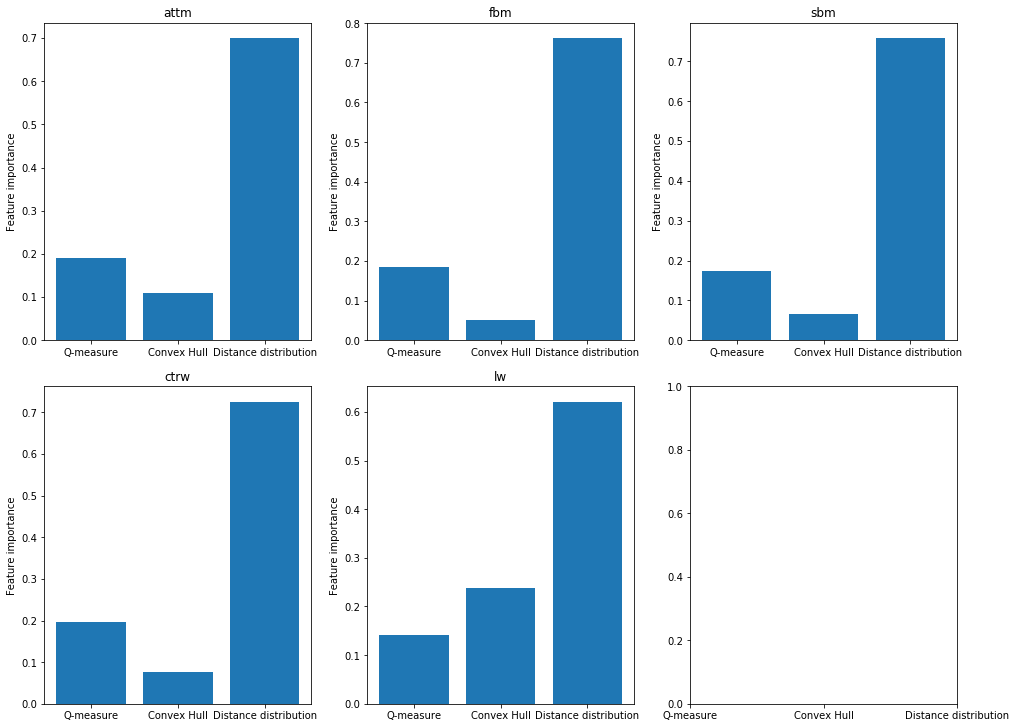

In [20]:
fig, axs = plt.subplots(nrows=2, ncols=3, constrained_layout=True, figsize=(14,10))

axs[0,0].set_title('attm')
axs[0,0].set_ylabel('Feature importance')
axs[0,0].bar(x_pos, attr_new[0], align='center')

axs[1,0].bar(x_pos, attr_new[1], align='center')
axs[1,0].set_ylabel('Feature importance')
axs[1,0].set_title('ctrw')


axs[0,1].bar(x_pos, attr_new[2], align='center')
axs[0,1].set_ylabel('Feature importance')
axs[0,1].set_title('fbm')

axs[1,1].bar(x_pos, attr_new[3], align='center')
axs[1,1].set_ylabel('Feature importance')
axs[1,1].set_title('lw')

axs[0,2].bar(x_pos, attr_new[4], align='center')
axs[0,2].set_ylabel('Feature importance')
axs[0,2].set_title('sbm')

plt.setp(axs, xticks=x_pos, xticklabels=feature_names)
plt.show()


## Test for different number of features

We now use different feature combination. 

In [3]:
# Here we create a tuple of features that we want to study 

features_new = (Q_measure(trajectories, 5),
            Q_measure(trajectories, 10),
            convex_hull(trajectories, 5),
            dist_distribution(trajectories))
input_tensor = torch.from_numpy(np.concatenate(features_new,axis=1)).type(torch.FloatTensor)

Epoch 0: train loss: 1.6126211881637573
Epoch 500: train loss: 0.9420599937438965
Epoch 1000: train loss: 0.9278583526611328
Epoch 1500: train loss: 0.9261949062347412
Epoch 2000: train loss: 0.9174988269805908
Epoch 2500: train loss: 0.9173119068145752
Epoch 3000: train loss: 0.9172505736351013
Epoch 3500: train loss: 0.9172194600105286
Epoch 4000: train loss: 0.9172050952911377
Epoch 4500: train loss: 0.9171966314315796


0.59

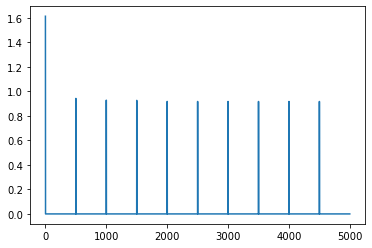

In [27]:
model = linnetwork(input_size=input_tensor.shape[1])
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

# Set random seed for reproducibility.

np.random.seed(10)
split = np.int(0.8*input_tensor.shape[0])

train_input, train_labels = input_tensor[:split,:], labels[:split]
test_input, test_labels = input_tensor[split:,:], labels[split:]


model.train()
epoch = 5000
loss_array = np.zeros(epoch)
for epoch in range(epoch):    
    optimizer.zero_grad()    # Forward pass
    y_pred = model(train_input)    # Compute Loss
    loss = criterion(y_pred.squeeze(), train_labels)
    if epoch % 500 == 0 :
        loss_array[epoch] =  loss.item()
        print('Epoch {}: train loss: {}'.format(epoch, loss.item()))    # Backward pass
    loss.backward()
    optimizer.step()
plt.plot(loss_array, '-')
    
solution =  model(test_input)
after_train = criterion(solution,test_labels)

prediction = torch.max(solution, 1)[1]


nonzero = np.count_nonzero(np.argmax(solution.detach().numpy(),axis=1)-test_labels.detach().numpy())
tot = len(np.argmax(solution.detach().numpy(),axis=1)-test_labels.detach().numpy())

(tot-nonzero)/tot

# usually around 0.76 for lr = 0.01



In [28]:
# test for captum feature importance 

ig = IntegratedGradients(model)

attr_list = [np.mean(ig.attribute(input_tensor,target=i, return_convergence_delta=True)[0].detach().numpy(), axis=0) for i in [0,1,2,3,4]]

f_sizes = np.cumsum([0]+[np.shape(i)[1] for i in features_new])
attr_new = [np.array([np.mean(np.abs(k[f_sizes[i]:f_sizes[i+1]])) for i in np.arange(0,len(f_sizes)-1)]) for k in attr_list]
attr_new = [i/np.sum(i)for i in attr_new]

feature_names = ('Q-measure 1','Q-measure 2','Convex Hull','Distance distribution')
x_pos = (np.arange(len(feature_names)))


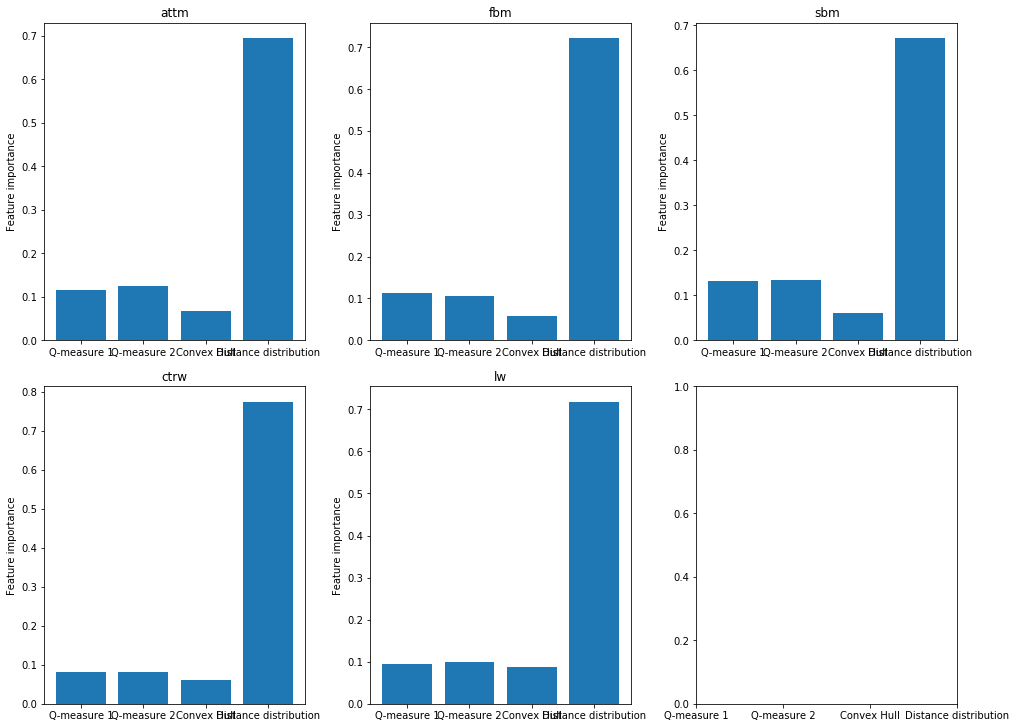

In [29]:
# we plot features importance as before but for new features added 

fig, axs = plt.subplots(nrows=2, ncols=3, constrained_layout=True, figsize=(14,10))

axs[0,0].set_title('attm')
axs[0,0].set_ylabel('Feature importance')
axs[0,0].bar(x_pos, attr_new[0], align='center')

axs[1,0].bar(x_pos, attr_new[1], align='center')
axs[1,0].set_ylabel('Feature importance')
axs[1,0].set_title('ctrw')


axs[0,1].bar(x_pos, attr_new[2], align='center')
axs[0,1].set_ylabel('Feature importance')
axs[0,1].set_title('fbm')

axs[1,1].bar(x_pos, attr_new[3], align='center')
axs[1,1].set_ylabel('Feature importance')
axs[1,1].set_title('lw')

axs[0,2].bar(x_pos, attr_new[4], align='center')
axs[0,2].set_ylabel('Feature importance')
axs[0,2].set_title('sbm')

plt.setp(axs, xticks=x_pos, xticklabels=feature_names)
plt.show()


# Interpretation of feature importance

Observations: 
1. for all trajectories types distance distribution plays the main role for feature learning. One still need to find agreement with previously found results in "Classification of diffusion modes in single-particle tracking data: Feature-based versus deep-learning approach" by  Patrycja Kowalek et al. 

2. when adding additional feature, which is not so different from existing ones, e.g. Q-measure for different window sizes we expect total feature importance (on average) to be the same for these features (or even to dicrease in total). This is teste below. 

3. feature for Q measure at least for 2 window sizes seems to be cumulative, while for 3 is not (?)

Issues: 
1. every simulation gives different feature importance (depedning on lr, other parameters).
2. need of analytical results for features importance given network configuration, e.g. lr, #epoches. 
3. previously in other studies only scalars values were tested for feature importance, e.g. MSD or diffusion coefficient 


Epoch 0: train loss: 1.6123303174972534
Epoch 500: train loss: 0.9342556595802307
Epoch 1000: train loss: 0.9177581071853638
Epoch 1500: train loss: 0.917397141456604
Epoch 2000: train loss: 0.9172759056091309
Epoch 2500: train loss: 0.9172150492668152
Epoch 3000: train loss: 0.9171777367591858
Epoch 3500: train loss: 0.9171534180641174
Epoch 4000: train loss: 0.9171398878097534
Epoch 4500: train loss: 0.917131245136261


0.63

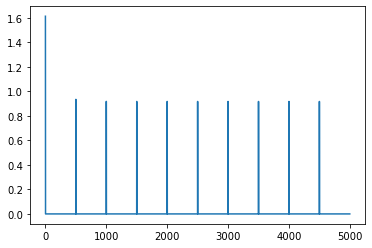

In [4]:


# Here we create a tuple of features that we want to study 

features_new = (Q_measure(trajectories, 5),
            Q_measure(trajectories, 10),
                Q_measure(trajectories, 20),
            convex_hull(trajectories, 5),
            dist_distribution(trajectories))
input_tensor = torch.from_numpy(np.concatenate(features_new,axis=1)).type(torch.FloatTensor)


model = linnetwork(input_size=input_tensor.shape[1])
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

# Set random seed for reproducibility.

np.random.seed(10)
split = np.int(0.8*input_tensor.shape[0])

train_input, train_labels = input_tensor[:split,:], labels[:split]
test_input, test_labels = input_tensor[split:,:], labels[split:]


model.train()
epoch = 5000
loss_array = np.zeros(epoch)
for epoch in range(epoch):    
    optimizer.zero_grad()    # Forward pass
    y_pred = model(train_input)    # Compute Loss
    loss = criterion(y_pred.squeeze(), train_labels)
    if epoch % 500 == 0 :
        loss_array[epoch] =  loss.item()
        print('Epoch {}: train loss: {}'.format(epoch, loss.item()))    # Backward pass
    loss.backward()
    optimizer.step()
plt.plot(loss_array, '-')
    
solution =  model(test_input)
after_train = criterion(solution,test_labels)

prediction = torch.max(solution, 1)[1]


nonzero = np.count_nonzero(np.argmax(solution.detach().numpy(),axis=1)-test_labels.detach().numpy())
tot = len(np.argmax(solution.detach().numpy(),axis=1)-test_labels.detach().numpy())

(tot-nonzero)/tot

# usually around 0.76 for lr = 0.01



Plot captum feature importance 

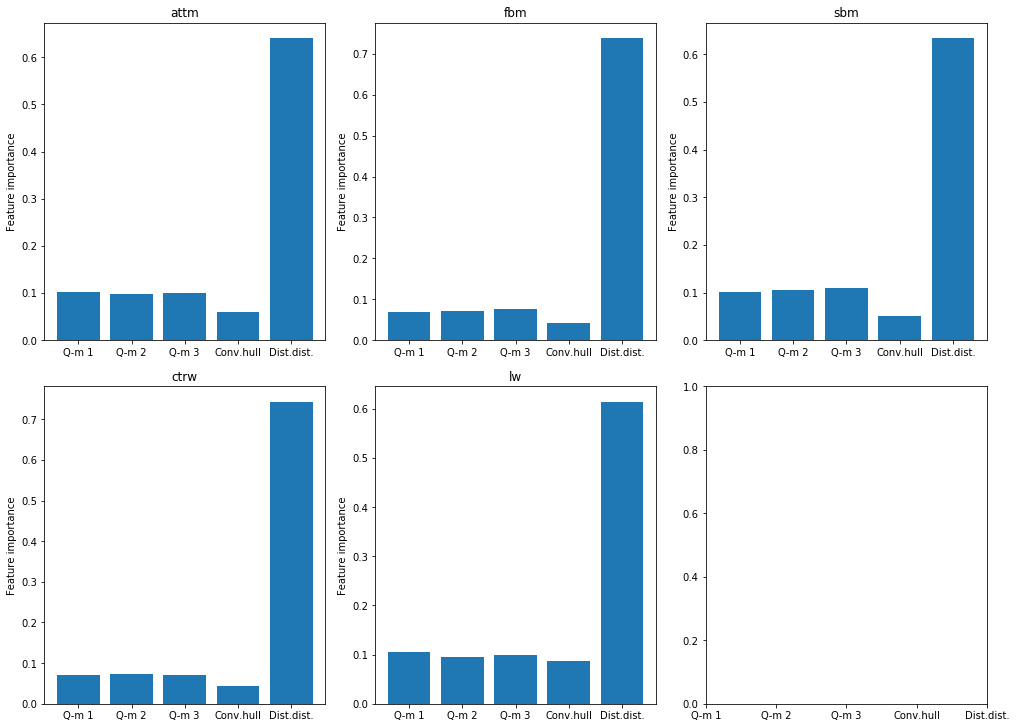

In [6]:
# test for captum feature importance 

ig = IntegratedGradients(model)

attr_list = [np.mean(ig.attribute(input_tensor,target=i, return_convergence_delta=True)[0].detach().numpy(), axis=0) for i in [0,1,2,3,4]]

f_sizes = np.cumsum([0]+[np.shape(i)[1] for i in features_new])
attr_new = [np.array([np.mean(np.abs(k[f_sizes[i]:f_sizes[i+1]])) for i in np.arange(0,len(f_sizes)-1)]) for k in attr_list]
attr_new = [i/np.sum(i)for i in attr_new]

feature_names = ('Q-m 1','Q-m 2', 'Q-m 3' , 'Conv.hull','Dist.dist.')
x_pos = (np.arange(len(feature_names)))

# we plot features importance as before but for new features added 

fig, axs = plt.subplots(nrows=2, ncols=3, constrained_layout=True, figsize=(14,10))

axs[0,0].set_title('attm')
axs[0,0].set_ylabel('Feature importance')
axs[0,0].bar(x_pos, attr_new[0], align='center')

axs[1,0].bar(x_pos, attr_new[1], align='center')
axs[1,0].set_ylabel('Feature importance')
axs[1,0].set_title('ctrw')


axs[0,1].bar(x_pos, attr_new[2], align='center')
axs[0,1].set_ylabel('Feature importance')
axs[0,1].set_title('fbm')

axs[1,1].bar(x_pos, attr_new[3], align='center')
axs[1,1].set_ylabel('Feature importance')
axs[1,1].set_title('lw')

axs[0,2].bar(x_pos, attr_new[4], align='center')
axs[0,2].set_ylabel('Feature importance')
axs[0,2].set_title('sbm')

plt.setp(axs, xticks=x_pos, xticklabels=feature_names)
plt.show()



We see that there is one feature (Q-measure for window size w=20), which may look more important than other window size Q-measures. We check it, if we get the same result for just two Q-measures with w=20 or without w=20. 

Epoch 0: train loss: 1.6230888366699219
Epoch 500: train loss: 0.9392871856689453
Epoch 1000: train loss: 0.925029456615448
Epoch 1500: train loss: 0.9246482849121094
Epoch 2000: train loss: 0.9244141578674316
Epoch 2500: train loss: 0.9243297576904297
Epoch 3000: train loss: 0.9243018627166748
Epoch 3500: train loss: 0.9242822527885437
Epoch 4000: train loss: 0.9242689609527588
Epoch 4500: train loss: 0.924103319644928


0.6

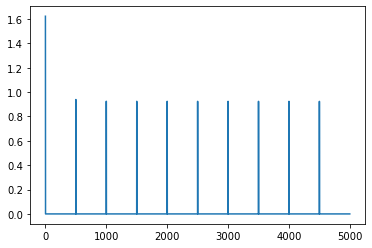

In [7]:


# Here we create a tuple of features that we want to study 

features_new = (Q_measure(trajectories, 5),
                Q_measure(trajectories, 20),
            convex_hull(trajectories, 5),
            dist_distribution(trajectories))
input_tensor = torch.from_numpy(np.concatenate(features_new,axis=1)).type(torch.FloatTensor)


model = linnetwork(input_size=input_tensor.shape[1])
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

# Set random seed for reproducibility.

np.random.seed(10)
split = np.int(0.8*input_tensor.shape[0])

train_input, train_labels = input_tensor[:split,:], labels[:split]
test_input, test_labels = input_tensor[split:,:], labels[split:]


model.train()
epoch = 5000
loss_array = np.zeros(epoch)
for epoch in range(epoch):    
    optimizer.zero_grad()    # Forward pass
    y_pred = model(train_input)    # Compute Loss
    loss = criterion(y_pred.squeeze(), train_labels)
    if epoch % 500 == 0 :
        loss_array[epoch] =  loss.item()
        print('Epoch {}: train loss: {}'.format(epoch, loss.item()))    # Backward pass
    loss.backward()
    optimizer.step()
plt.plot(loss_array, '-')
    
solution =  model(test_input)
after_train = criterion(solution,test_labels)

prediction = torch.max(solution, 1)[1]


nonzero = np.count_nonzero(np.argmax(solution.detach().numpy(),axis=1)-test_labels.detach().numpy())
tot = len(np.argmax(solution.detach().numpy(),axis=1)-test_labels.detach().numpy())

(tot-nonzero)/tot

# usually around 0.76 for lr = 0.01



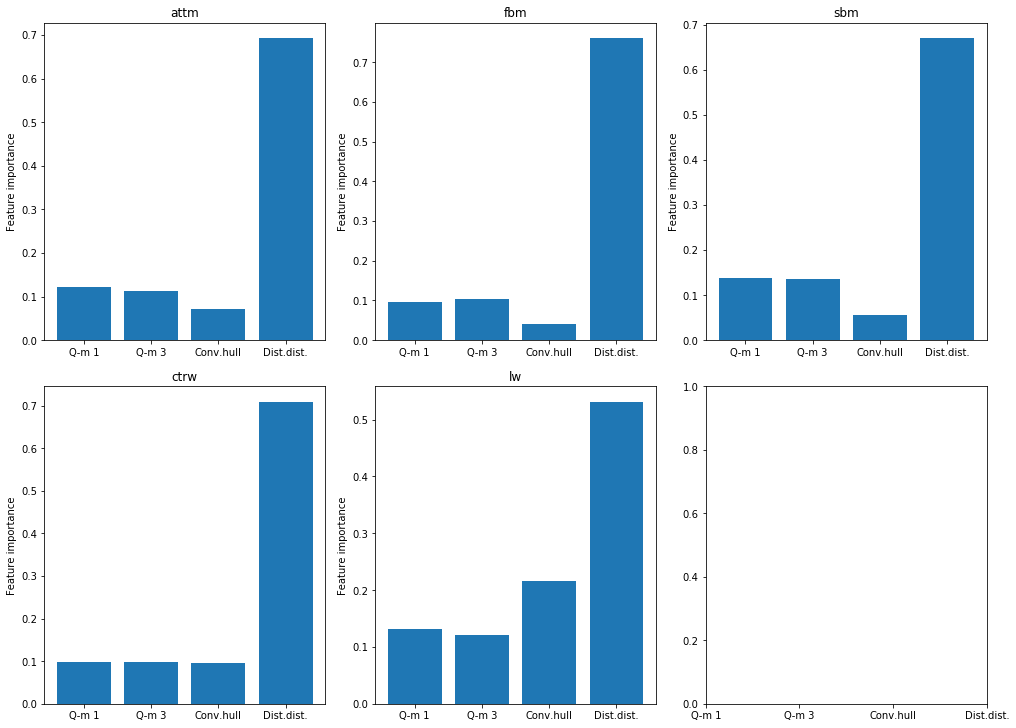

In [8]:
# test for captum feature importance 

ig = IntegratedGradients(model)

attr_list = [np.mean(ig.attribute(input_tensor,target=i, return_convergence_delta=True)[0].detach().numpy(), axis=0) for i in [0,1,2,3,4]]

f_sizes = np.cumsum([0]+[np.shape(i)[1] for i in features_new])
attr_new = [np.array([np.mean(np.abs(k[f_sizes[i]:f_sizes[i+1]])) for i in np.arange(0,len(f_sizes)-1)]) for k in attr_list]
attr_new = [i/np.sum(i)for i in attr_new]

feature_names = ('Q-m 1', 'Q-m 3' , 'Conv.hull','Dist.dist.')
x_pos = (np.arange(len(feature_names)))

# we plot features importance as before but for new features added 

fig, axs = plt.subplots(nrows=2, ncols=3, constrained_layout=True, figsize=(14,10))

axs[0,0].set_title('attm')
axs[0,0].set_ylabel('Feature importance')
axs[0,0].bar(x_pos, attr_new[0], align='center')

axs[1,0].bar(x_pos, attr_new[1], align='center')
axs[1,0].set_ylabel('Feature importance')
axs[1,0].set_title('ctrw')


axs[0,1].bar(x_pos, attr_new[2], align='center')
axs[0,1].set_ylabel('Feature importance')
axs[0,1].set_title('fbm')

axs[1,1].bar(x_pos, attr_new[3], align='center')
axs[1,1].set_ylabel('Feature importance')
axs[1,1].set_title('lw')

axs[0,2].bar(x_pos, attr_new[4], align='center')
axs[0,2].set_ylabel('Feature importance')
axs[0,2].set_title('sbm')

plt.setp(axs, xticks=x_pos, xticklabels=feature_names)
plt.show()



## Observations 

It seems that window size $w=20$ at least numerically does not bring so much new information in comparison to $w=10$, but 
when adding more Q-measures in total it gives higher cumulative feature importance, which is interesting non-additive feature (to be tested more). 

# Input of trajectory itself as a feature
Let us now input the trajectory itslef as a new feature. 


In [4]:



# Initial imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import os
import sys
sys.path.append('../')
import torch
import torch.nn as nn

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

#from src.features import Q_measure, dist_distribution, convex_hull
from src.andi_tools import Andi_to_xy, Data_to_xy
from src.training import linnetwork


from src.features import Q_measure, dist_distribution, convex_hull, traject_itself
from src.andi_tools import Andi_to_xy, Data_to_xy
from src.training import linnetwork



In [3]:
# Here we create a tuple of features that we want to study 

features = (Q_measure(trajectories, 5),
            convex_hull(trajectories, 5),
            dist_distribution(trajectories),
           traject_itself(trajectories))
input_tensor = torch.from_numpy(np.concatenate(features,axis=1)).type(torch.FloatTensor)

TypeError: concatenate() got multiple values for argument 'axis'